# Problem Scaling

**Note: This file is a nearly-exact word-for-word copy of [this blog post from the CasADi blog](https://web.casadi.org/blog/nlp-scaling/), converted to AeroSandbox syntax - original authorship not claimed here.**

It is so, so important to "scale" your variables so that your optimization problem is "well-scaled". Here, "scaling" means that a variable is multiplied or divided by some associated constant before it is passed into the optimizer, so that the optimizer sees a value that is ideally on the order of 0.01 to 100.

A 2nd-order Newton-step optimization method is theoretically scale-invariant with enough precision - this means that scaling shouldn't matter. However, because scientific computing using floating-point arithmetic with finite precision, scaling can make a huge difference in the conditioning of the Lagrangian hessian and constraints jacobian. Furthermore, some treatments within IPOPT (the underlying solver that AeroSandbox uses) are not scale invariant. Therefore, scaling is key.

This issue of scaling is especially important in engineering design optimization, where problems frequently have variables that span many orders of magnitude if left unscaled (e.g. a plate thickness on the order of 1e-4 meters and an internal stress on the order of 1e8 Pascals).

In AeroSandbox, you can set the scale factor for a given variable with the parameter scale:
```python
import aerosandbox as asb
opti = asb.Opti()
x = opti.variable(init_guess = 5, scale = 10)
```

Similarly, you can set the scale of vector variables with either a constant or a vector of equal length (in which case scales are applied element-wise).

Because the issue of scaling is so, so important, AeroSandbox will automatically attempt to scale your variables under the hood using some heuristics based on your initial guess. However, if your initial guess does not accurately represent the approximate value of your variable (**and in particular, if your initial guess is zero**), you should manually specify a scale for each variable.

Let's illustrate how much of a difference proper scaling can make:

-----

Master student Thomas Durbin stumbled upon a dramatic example of bad scaling in practice. He works on optimal control for rockets. As a first toy problem, he studied a 1D rocket that must attain a certain height at $t=100$ seconds, with minimal expenditure of fuel. Following good engineering practice, he used SI base units to write the code.

The gist of the code is as follows (complete code [here](https://web.casadi.org/blog/nlp-scaling/rocket.m)): (Note: this code has been converted to AeroSandbox syntax, and variables have been given more readable names.)

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

### Parameters
N = 100  # Number of discretization points
time_final = 100  # seconds
time = np.linspace(0, time_final, N)

### Constants
mass_initial = 500e3  # Initial mass, 500 metric tons
y_final = 100e3  # Final altitude, 100 km
g = 9.81  # Gravity, m/s^2
alpha = 1 / (
    300 * g
)  # kg/(N*s), Inverse of specific impulse, basically - don't worry about this

### Environment
opti = asb.Opti()

### Variables
y = opti.variable(init_guess=np.linspace(0, y_final, N), scale=1)  # Altitude
velocity = opti.variable(init_guess=y_final / time_final, scale=1, n_vars=N)  # Velocity
mass = opti.variable(init_guess=mass_initial, scale=1, n_vars=N)  # Mass
u = opti.variable(init_guess=g * mass_initial, scale=1, n_vars=N)  # Control vector

### Dynamics (implemented manually for now, we'll show you more sophisticated ways to do this in the Trajectory
# Optimization part of the tutorial later on)
opti.subject_to(
    [  # Forward Euler, implemented manually for now
        np.diff(y) == velocity[:-1] * np.diff(time),
        np.diff(velocity) == (u[:-1] / mass[:-1] - g) * np.diff(time),
        np.diff(mass) == (-alpha * u[:-1]) * np.diff(time),
    ]
)

### Boundary conditions
opti.subject_to(
    [y[0] == 0, velocity[0] == 0, mass[0] == mass_initial, y[-1] == y_final]
)

### Path constraints
opti.subject_to([mass >= 0, u >= 0])

### Objective
opti.minimize(-mass[-1])  # Maximize the final mass == minimize fuel expenditure

### Solve
sol = opti.solve(verbose=False)
print(f"Solved in {sol.stats()['iter_count']} iterations.")

Solved in 20 iterations.


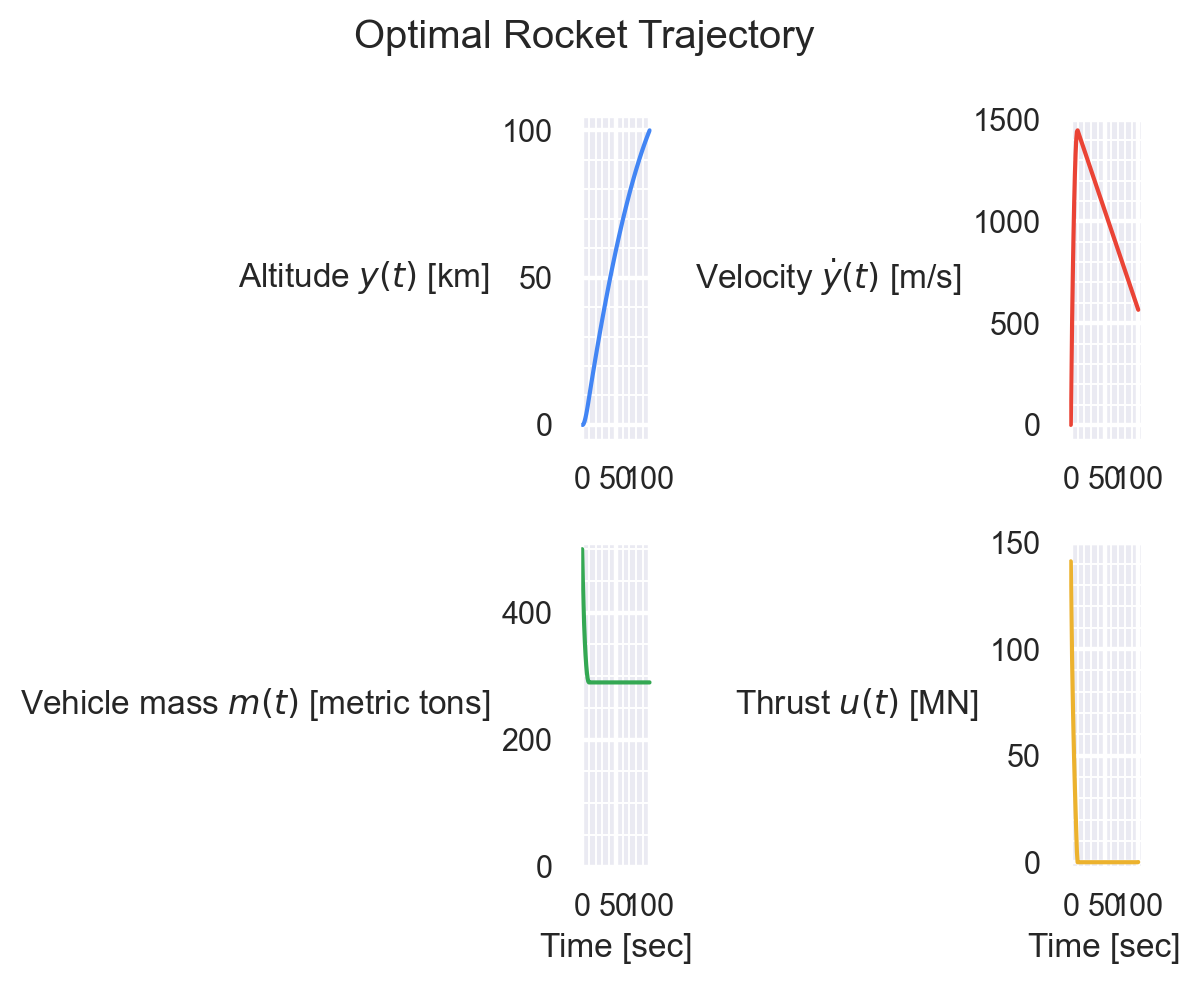

In [2]:
### Plot
from aerosandbox.tools.pretty_plots import plt, sns, show_plot, palettes
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(2, 2, figsize=(6, 5))

plt.sca(ax[0, 0])
plt.plot(time, sol(y / 1e3), color=palettes["categorical"][0])
plt.ylabel(r"Altitude $y(t)$ [km]")

plt.sca(ax[0, 1])
plt.plot(time, sol(velocity), color=palettes["categorical"][1])
plt.ylabel(r"Velocity $\dot{y}(t)$ [m/s]")
plt.gca().yaxis.set_minor_locator(MultipleLocator(250))

plt.sca(ax[1, 0])
plt.plot(time, sol(mass / 1e3), color=palettes["categorical"][2])
plt.ylabel(r"Vehicle mass $m(t)$ [metric tons]")
plt.ylim(bottom=0)
plt.gca().yaxis.set_major_locator(MultipleLocator(100))
plt.gca().yaxis.set_minor_locator(MultipleLocator(100))

plt.sca(ax[1, 1])
plt.plot(time, sol(u / 1e6), color=palettes["categorical"][3])
plt.ylabel(r"Thrust $u(t)$ [MN]")
plt.ylim(-2, 150)
plt.gca().yaxis.set_minor_locator(MultipleLocator(25))

for a in ax.flatten():
    a.xaxis.set_minor_locator(MultipleLocator(10))

ax[1, 0].set_xlabel("Time [sec]")
ax[1, 1].set_xlabel("Time [sec]")
show_plot(title="Optimal Rocket Trajectory", show=False)
# plt.savefig(r"C:\Users\User\Dropbox (MIT)\School\Grad School\2021 Spring\Thesis\TeX\figures\rocket-trajectory.pgf")

plt.show()

Sweet! Cool trajectory, and that seems about right.

But the focus is here on convergence. It's pretty lousy.

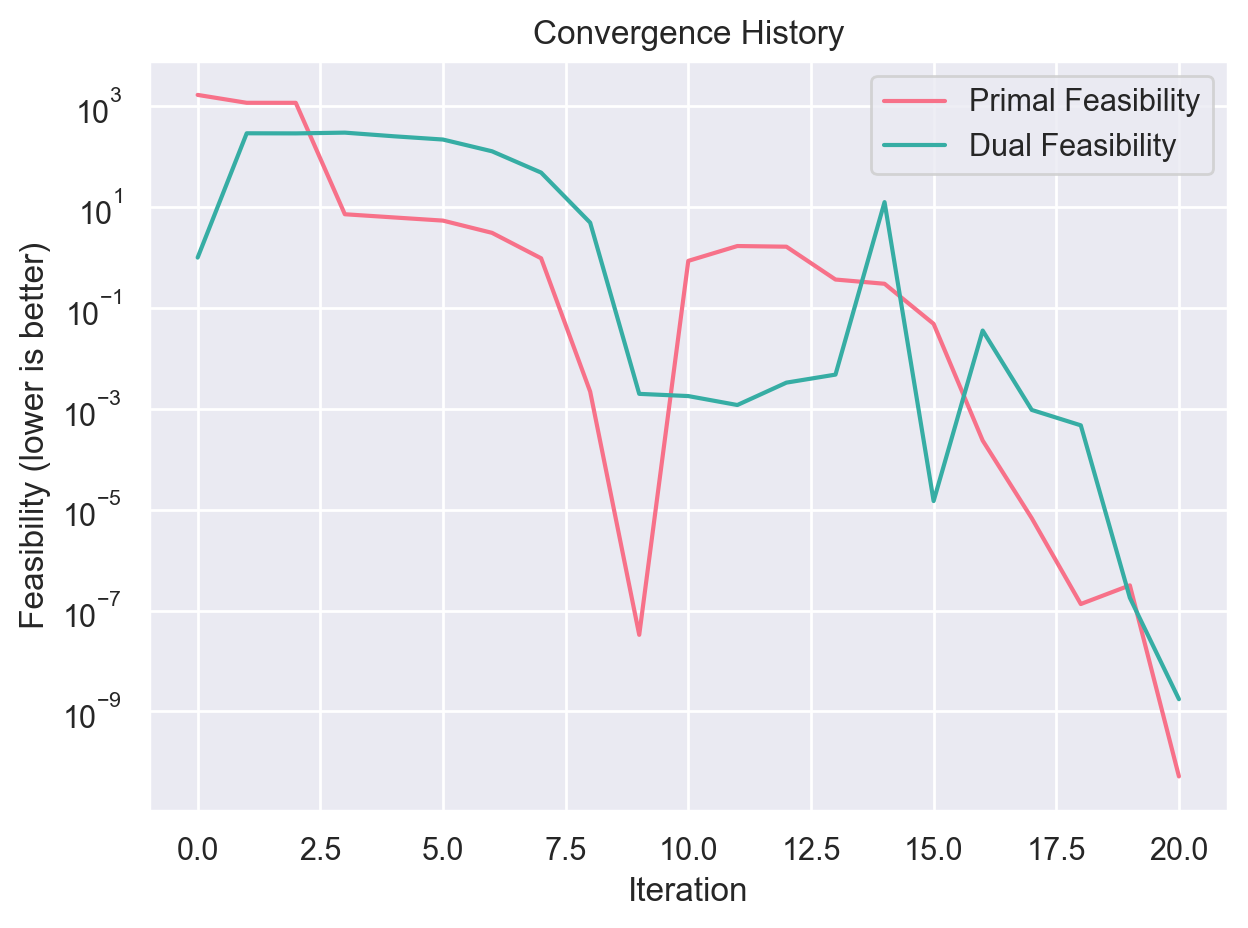

In [3]:
sns.set(palette=sns.color_palette("husl", 2))
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
plt.semilogy(sol.stats()["iterations"]["inf_pr"], label="Primal Feasibility")
plt.semilogy(sol.stats()["iterations"]["inf_du"], label="Dual Feasibility")
plt.xlabel(r"Iteration")
plt.ylabel(r"Feasibility (lower is better)")
plt.title(r"Convergence History")
plt.tight_layout()
plt.legend()
plt.show()

What if we simply scale the variables?

In [4]:
### Parameters
N = 100  # Number of discretization points
time_final = 100  # seconds
time = np.linspace(0, time_final, N)

### Constants
mass_initial = 500e3  # Initial mass, 500 metric tons
y_final = 100e3  # Final altitude, 100 km
g = 9.81  # Gravity, m/s^2
alpha = 1 / (
    300 * g
)  # kg/(N*s), Inverse of specific impulse, basically - don't worry about this

### Environment
opti = asb.Opti()

### Variables
y = opti.variable(init_guess=np.linspace(0, y_final, N))  # Altitude
velocity = opti.variable(init_guess=y_final / time_final, n_vars=N)  # Velocity
mass = opti.variable(init_guess=mass_initial, n_vars=N)  # Mass
u = opti.variable(init_guess=g * mass_initial, n_vars=N)  # Control vector

### Dynamics (implemented manually for now, we'll show you more sophisticated ways to do this in the Trajectory
# Optimization part of the tutorial later on)
opti.subject_to(
    [  # Forward Euler, implemented manually for now
        np.diff(y) == velocity[:-1] * np.diff(time),
        np.diff(velocity) == (u[:-1] / mass[:-1] - g) * np.diff(time),
        np.diff(mass) == (-alpha * u[:-1]) * np.diff(time),
    ]
)

### Boundary conditions
opti.subject_to(
    [y[0] == 0, velocity[0] == 0, mass[0] == mass_initial, y[-1] == y_final]
)

### Path constraints
opti.subject_to([mass >= 0, u >= 0])

### Objective
opti.minimize(-mass[-1])  # Maximize the final mass == minimize fuel expenditure

### Solve
sol = opti.solve(verbose=False)
print(f"Solved in {sol.stats()['iter_count']} iterations.")

Solved in 12 iterations.


Exact same solution, wildly different convergence:

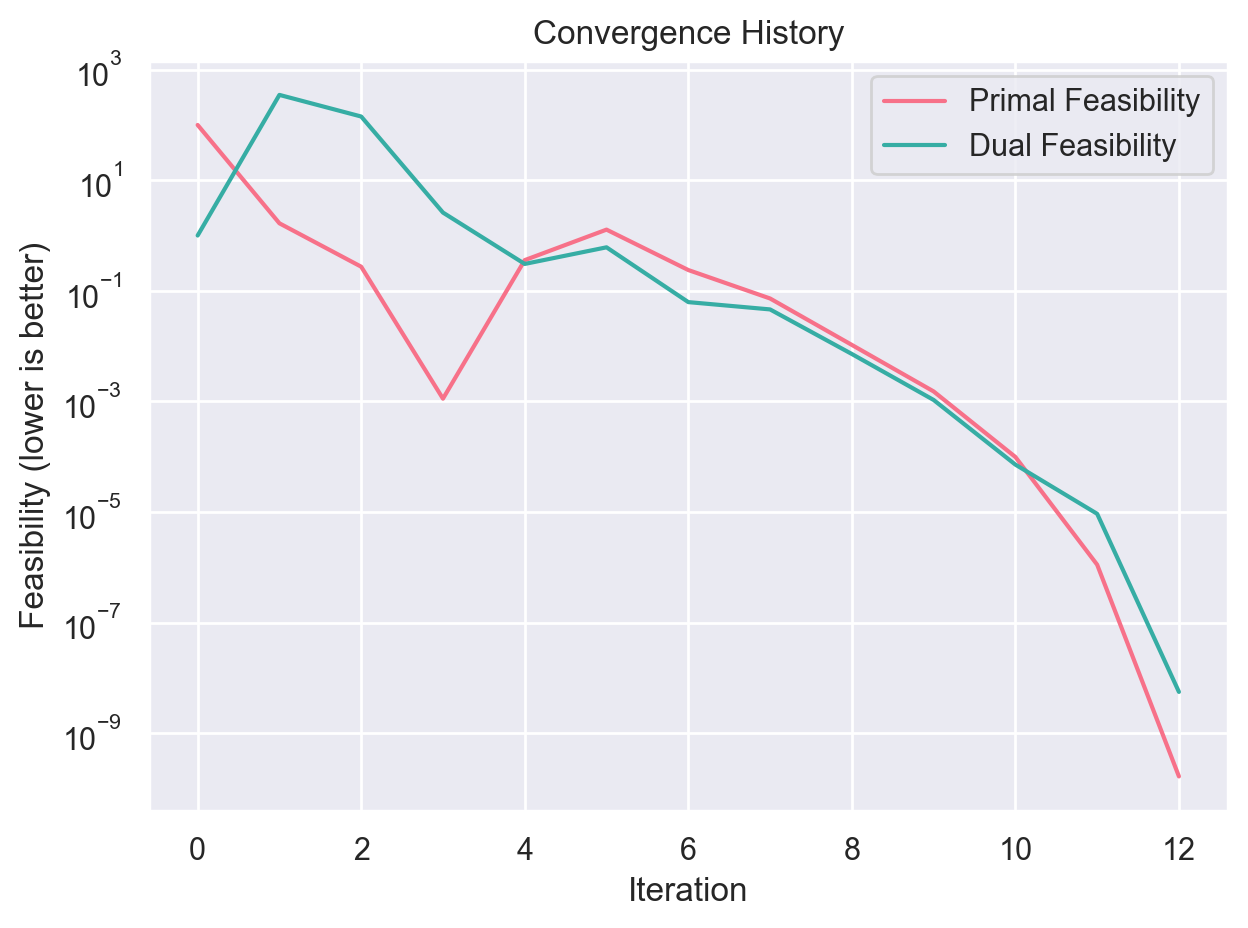

In [5]:
sns.set(palette=sns.color_palette("husl", 2))
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
plt.semilogy(sol.stats()["iterations"]["inf_pr"], label="Primal Feasibility")
plt.semilogy(sol.stats()["iterations"]["inf_du"], label="Dual Feasibility")
plt.xlabel(r"Iteration")
plt.ylabel(r"Feasibility (lower is better)")
plt.title(r"Convergence History")
plt.tight_layout()
plt.legend()
plt.show()

Runtimes will vary from machine to machine, but on my computer, a simple scaling **speeds up the optimization by around 60x**.

In conclusion, even with automatic differentiation via CasADi to provide derivatives at machine precision, and even with a solver (IPOPT) that [provides auto-scaling](https://www.coin-or.org/Ipopt/documentation/node43.html), it's still good practice to scale your NLP manually using the `scale` parameter of `opti.variable()`!

## Addendum

Guidelines for scaling involve more than just scaling of the variables. In IPOPT, objective and constraints (but not variables) are scaled automatically, using first-order sensitivities at the initial guess. This is vital for the above example to work. Without it, we need to scale objective and constraints ourselves.

**Once again, this section of the tutorial was reproduced from [the CasADi blog here](https://web.casadi.org/blog/nlp-scaling/), converted to AeroSandbox syntax - see here for more info.**